# Data Cleaning

In [93]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import warnings

In [94]:
import kagglehub
from pathlib import Path

# Download latest version
path = kagglehub.dataset_download("amitabhajoy/bengaluru-house-price-data")
csv_path = next(Path(path).rglob("*.csv"))

df1 = pd.read_csv(csv_path)
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [95]:
df1.shape

(13320, 9)

In [96]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [97]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [98]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [99]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [100]:
df3.shape

(13246, 5)

In [101]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [102]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

In [103]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [104]:
df3[df3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [105]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2067,), dtype=object)

In [106]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [107]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [108]:
import re

def convert_sqft_to_num(x):
    if pd.isna(x):
        return None
    x = str(x).strip().lower().replace(',', '')

    tokens = x.split('-')
    if len(tokens) == 2:
        try:
            return (float(tokens[0]) + float(tokens[1])) / 2
        except:
            nums = []
            for t in tokens:
                m = re.search(r"[\d.]+", t)
                if m:
                    nums.append(float(m.group()))
            return sum(nums)/len(nums) if nums else None

    try:
        return float(x)
    except:
        m = re.search(r"[\d.]+", x)
        if not m:
            return None
        val = float(m.group())

        # pulisci l'unità (solo lettere)
        unit = re.sub(r"[^a-z]", "", x)

        if "perch" in unit:
            return round(val * 272.25, 2)       # perch -> sqft
        if "sqm" in unit or "sqmeter" in unit or "sqmetre" in unit or "meter" in unit or "metre" in unit:
            return round(val * 10.7639, 2)      # sqm -> sqft
        if "sqft" in unit or "squarefeet" in unit:
            return round(val, 2)

        return None

In [109]:
convert_sqft_to_num('4125Perch')

1123031.25

In [110]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [111]:
#Just to verify if it worked
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [112]:
df4.loc[410]

location      Kengeri
size            1 BHK
total_sqft     370.92
bath              1.0
price            18.5
bhk                 1
Name: 410, dtype: object

# Feature Engineering

In [113]:
df5 = df4.copy()
df5['price_per_sqft'] = round(df5['price']*100000/df5['total_sqft'],2) #multiply for 100000 because the price is in lakh rupees
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.89
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.00


In [114]:
df5.location.unique(), len(df5.location.unique())

(array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
        '12th cross srinivas nagar banshankari 3rd stage',
        'Havanur extension', 'Abshot Layout'], shape=(1304,), dtype=object),
 1304)

In [115]:
df5.location = df5.location.apply(lambda x: x.strip())

location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield                            535
Sarjapur  Road                        392
Electronic City                       304
Kanakpura Road                        266
Thanisandra                           236
                                     ... 
poornaprajna layout                     1
pavitra paradise                        1
near Ramanashree California resort      1
mvj engineering college                 1
1Kasavanhalli                           1
Name: location, Length: 1293, dtype: int64

In [116]:
len(location_stats[location_stats<=10])

1052

In [117]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Kalkere                               10
Sadashiva Nagar                       10
BTM 1st Stage                         10
Basapura                              10
Gunjur Palya                          10
                                      ..
poornaprajna layout                    1
pavitra paradise                       1
near Ramanashree California resort     1
mvj engineering college                1
1Kasavanhalli                          1
Name: location, Length: 1052, dtype: int64

In [118]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

242

In [119]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.81
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.38
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.56
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.89
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.00
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.86
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.06
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.82
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.24
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.51


# Outlier Removal

In [120]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.51
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.33
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.98
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.30
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.00


In [121]:
df5.shape

(13246, 7)

In [122]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12501, 7)

In [123]:
df6.price_per_sqft.describe()

count     12473.000000
mean       6305.340132
std        4167.648086
min          23.600000
25%        4208.750000
50%        5292.870000
75%        6917.000000
max      176470.590000
Name: price_per_sqft, dtype: float64

In [124]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [125]:
df7 = remove_pps_outliers(df6)
df7.shape

(10255, 7)

In [126]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

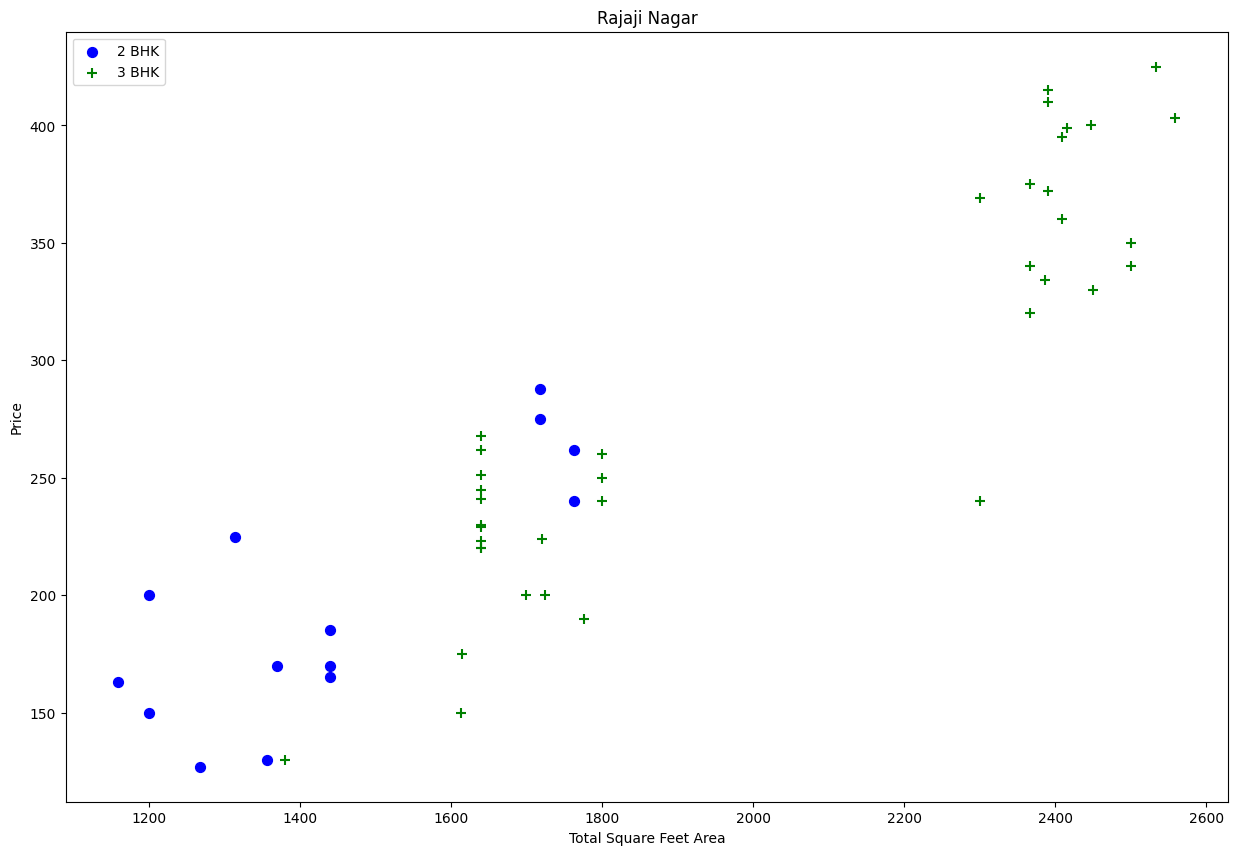

In [127]:
plot_scatter_chart(df7, "Rajaji Nagar")

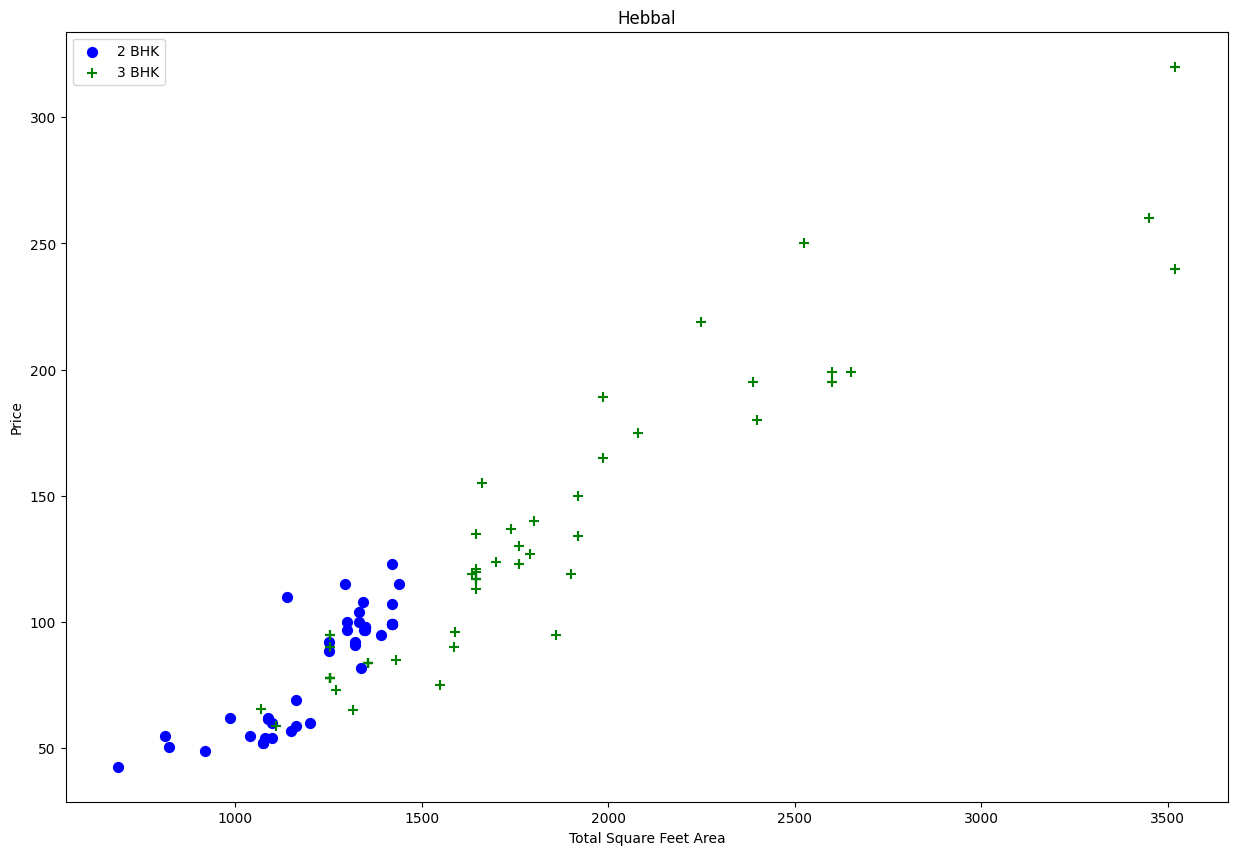

In [128]:
plot_scatter_chart(df7, "Hebbal")

Remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with the same square ft area).
Given a location, build a dictionary of stats per bhk, i.e.

    {
        '1' : {
            'mean': 4000,
            'std': 2000,
            'count': 34,
        },
        '2' : {
            'mean': 4300,
            'std': 2300,
            'count': 22,
        },
    }

In [129]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [130]:
df8 = remove_bhk_outliers(df7)
df8.shape

(7336, 7)

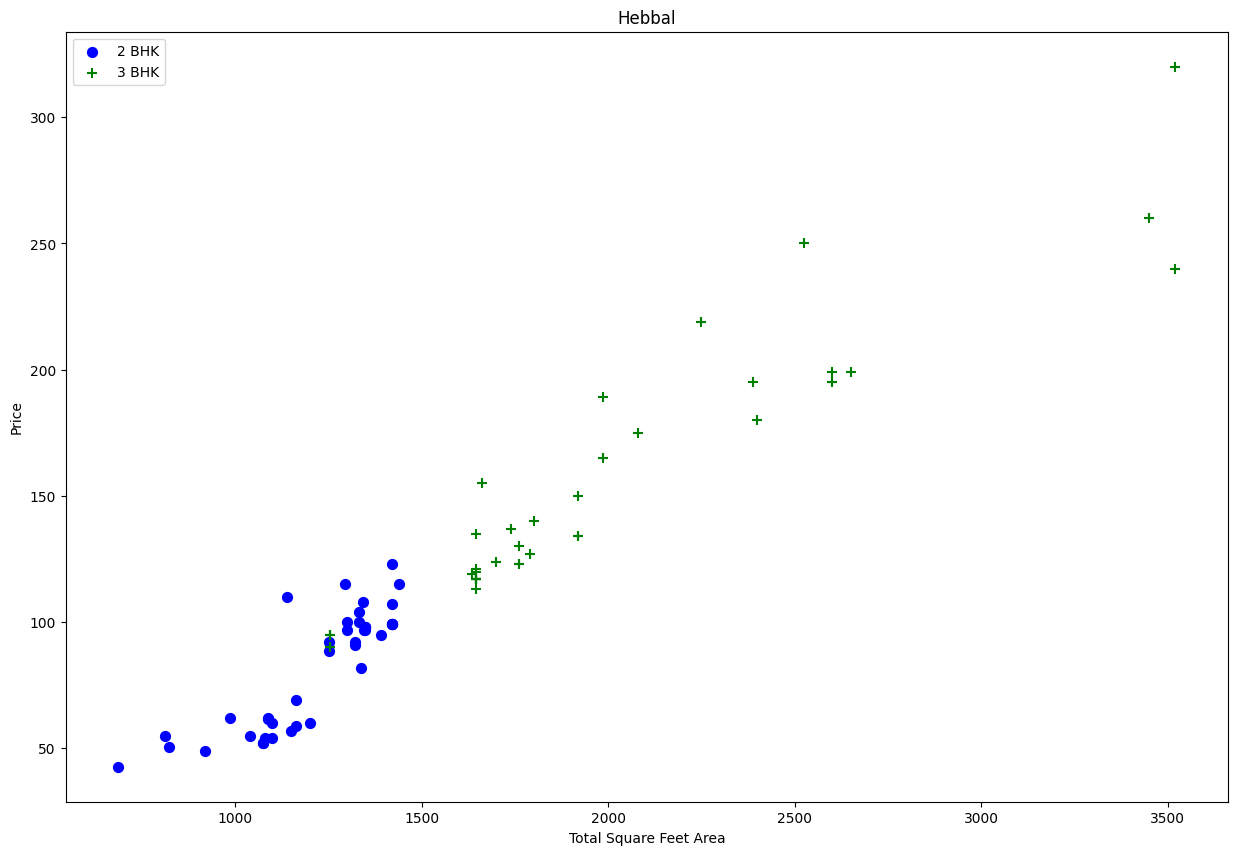

In [131]:
# Proof
plot_scatter_chart(df8, "Hebbal")

Text(0, 0.5, 'Count')

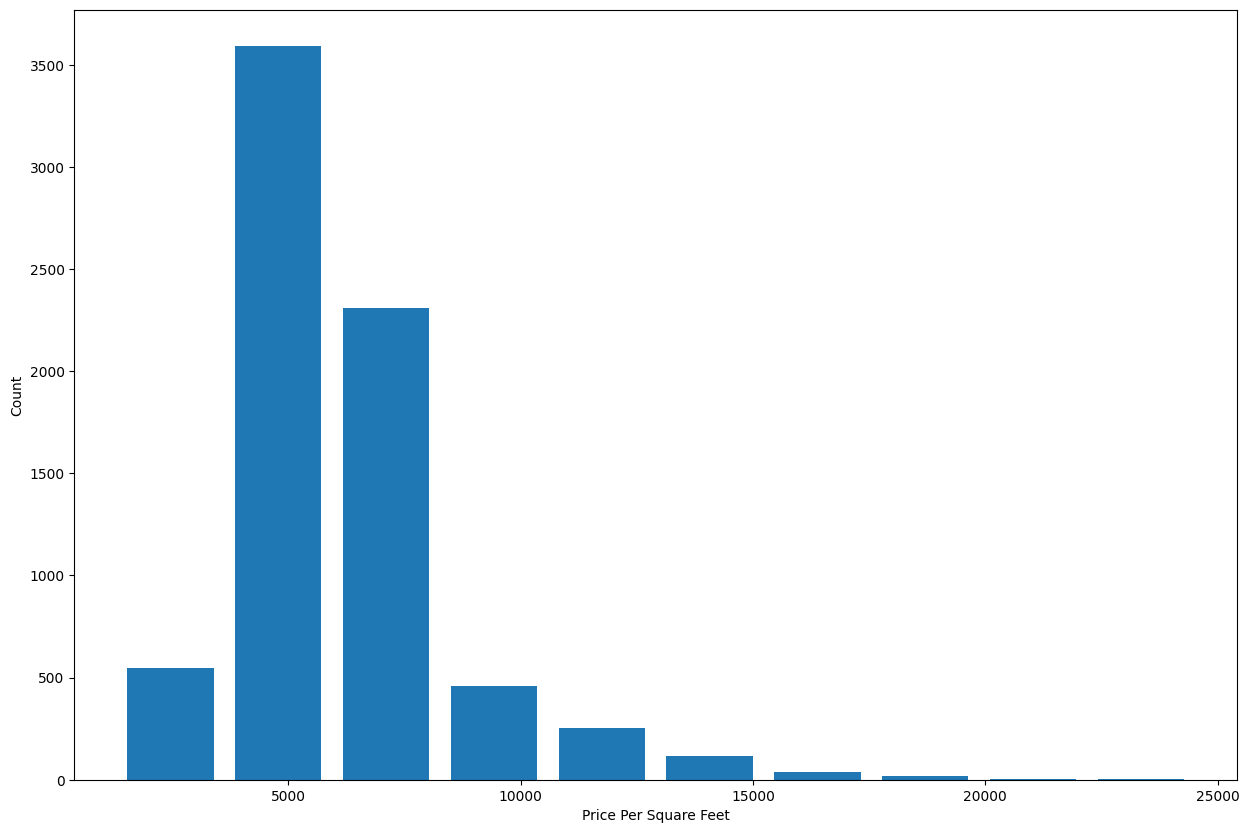

In [132]:
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

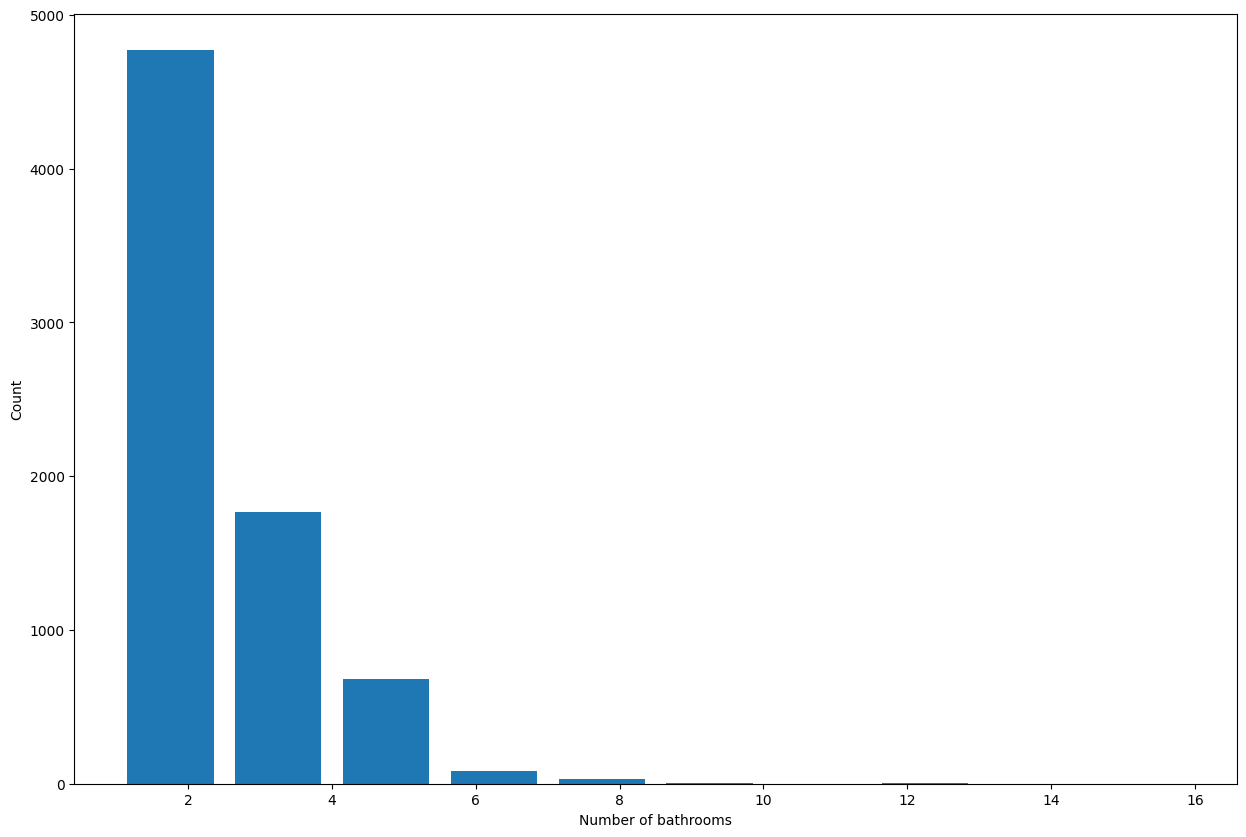

In [133]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [134]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1628,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.03
5247,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.57
6722,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.03
8423,other,6 BHK,11338.0,9.0,1000.0,6,8819.90


In [135]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7258, 7)

In [136]:
df10 = df9.drop(['size','price_per_sqft'], axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# Model Building

In [137]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [138]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [139]:
df12 = df11.drop('location', axis='columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,235.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,130.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,148.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [140]:
df12.shape

(7258, 245)

In [141]:
X = df12.drop('price', axis='columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [142]:
y = df12.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8756616153766823

In [145]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.87566162, 0.8188946 , 0.82011464, 0.87919066, 0.86371869])

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error','friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [147]:
find_best_model_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.851817,{'fit_intercept': False}
1,lasso,0.703179,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.735347,"{'criterion': 'squared_error', 'splitter': 'be..."


In [148]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [149]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    
    return lr_clf.predict([x])[0]

In [150]:
warnings.filterwarnings("ignore")
predict_price('1st Block Jayanagar', 1000, 2, 3)

np.float64(177.15141028536598)

In [151]:
warnings.filterwarnings("ignore")
predict_price('1st Block Jayanagar', 1000, 3, 3)

np.float64(180.6363770650495)

In [152]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf, f)

In [153]:
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))